## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.preprocessing import FraudPreprocessor
from src.models.lgbm_baseline import LGBMBaseline
from src.utils import (
    plot_roc_curve, 
    plot_confusion_matrix, 
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Advanced Feature Engineering

### 3.1 Basic Time Features

In [4]:
# Create time features
print("Creating time features...")

# TransactionDT is in seconds, convert to more useful units
train_df['DT_day'] = train_df['TransactionDT'] // (24 * 60 * 60)
train_df['DT_hour'] = (train_df['TransactionDT'] // (60 * 60)) % 24
train_df['DT_day_of_week'] = (train_df['DT_day'] % 7)
train_df['DT_is_weekend'] = (train_df['DT_day_of_week'] >= 5).astype(int)

# Hour bins
train_df['DT_hour_bin'] = pd.cut(train_df['DT_hour'], bins=[0, 6, 12, 18, 24], 
                                   labels=['night', 'morning', 'afternoon', 'evening'])

print(f"✓ Time features created: {['DT_day', 'DT_hour', 'DT_day_of_week', 'DT_is_weekend', 'DT_hour_bin']}")

Creating time features...
✓ Time features created: ['DT_day', 'DT_hour', 'DT_day_of_week', 'DT_is_weekend', 'DT_hour_bin']


### 3.2 Transaction Amount Features

In [5]:
# Transaction amount engineering
print("Creating transaction amount features...")

# Log transform
train_df['TransactionAmt_log'] = np.log1p(train_df['TransactionAmt'])

# Decimal part (research shows this is predictive)
train_df['TransactionAmt_decimal'] = train_df['TransactionAmt'] - train_df['TransactionAmt'].astype(int)

# Amount bins
train_df['TransactionAmt_bin'] = pd.qcut(train_df['TransactionAmt'], q=10, labels=False, duplicates='drop')

# Round amounts (people often transact in round numbers)
train_df['TransactionAmt_is_round'] = (train_df['TransactionAmt'] == train_df['TransactionAmt'].round()).astype(int)

print(f"✓ Amount features created: {['TransactionAmt_log', 'TransactionAmt_decimal', 'TransactionAmt_bin', 'TransactionAmt_is_round']}")

Creating transaction amount features...
✓ Amount features created: ['TransactionAmt_log', 'TransactionAmt_decimal', 'TransactionAmt_bin', 'TransactionAmt_is_round']


### 3.3 Email Domain Features

In [6]:
# Extract email domain features
print("Creating email domain features...")

# P_emaildomain features
if 'P_emaildomain' in train_df.columns:
    # Extract top-level domain
    train_df['P_email_tld'] = train_df['P_emaildomain'].fillna('unknown').str.split('.').str[-1]
    
    # Common email providers
    common_providers = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com', 'aol.com']
    train_df['P_email_is_common'] = train_df['P_emaildomain'].isin(common_providers).astype(int)

# R_emaildomain features
if 'R_emaildomain' in train_df.columns:
    train_df['R_email_tld'] = train_df['R_emaildomain'].fillna('unknown').str.split('.').str[-1]
    train_df['R_email_is_common'] = train_df['R_emaildomain'].isin(common_providers).astype(int)

# Email domain match
if 'P_emaildomain' in train_df.columns and 'R_emaildomain' in train_df.columns:
    train_df['email_domains_match'] = (train_df['P_emaildomain'] == train_df['R_emaildomain']).astype(int)

print("✓ Email domain features created")

Creating email domain features...
✓ Email domain features created
✓ Email domain features created


### 3.4 Device Information Features

In [7]:
# Parse device info
print("Creating device info features...")

if 'DeviceInfo' in train_df.columns:
    # Extract device type (first word)
    train_df['DeviceInfo_device'] = train_df['DeviceInfo'].fillna('unknown').str.split().str[0]
    
    # Device info length (complexity measure)
    train_df['DeviceInfo_length'] = train_df['DeviceInfo'].fillna('').astype(str).str.len()
    
    # Check for specific keywords
    train_df['DeviceInfo_has_SM'] = train_df['DeviceInfo'].fillna('').str.contains('SM', case=False).astype(int)
    train_df['DeviceInfo_has_Windows'] = train_df['DeviceInfo'].fillna('').str.contains('Windows', case=False).astype(int)
    train_df['DeviceInfo_has_iOS'] = train_df['DeviceInfo'].fillna('').str.contains('iOS', case=False).astype(int)

print("✓ Device info features created")

Creating device info features...
✓ Device info features created
✓ Device info features created


### 3.5 Null Pattern Features

In [8]:
# Null patterns (highly predictive in fraud detection)
print("Creating null pattern features...")

# Count nulls per row
train_df['null_count'] = train_df.isnull().sum(axis=1)

# Null percentage
train_df['null_percentage'] = train_df['null_count'] / train_df.shape[1]

# Specific feature groups null counts
v_cols = [col for col in train_df.columns if col.startswith('V')]
c_cols = [col for col in train_df.columns if col.startswith('C')]
d_cols = [col for col in train_df.columns if col.startswith('D')]
m_cols = [col for col in train_df.columns if col.startswith('M')]

train_df['null_count_V'] = train_df[v_cols].isnull().sum(axis=1)
train_df['null_count_C'] = train_df[c_cols].isnull().sum(axis=1)
train_df['null_count_D'] = train_df[d_cols].isnull().sum(axis=1)
train_df['null_count_M'] = train_df[m_cols].isnull().sum(axis=1)

print(f"✓ Null pattern features created: {['null_count', 'null_percentage', 'null_count_V', 'null_count_C', 'null_count_D', 'null_count_M']}")

Creating null pattern features...
✓ Null pattern features created: ['null_count', 'null_percentage', 'null_count_V', 'null_count_C', 'null_count_D', 'null_count_M']
✓ Null pattern features created: ['null_count', 'null_percentage', 'null_count_V', 'null_count_C', 'null_count_D', 'null_count_M']


### 3.6 Aggregation Features (Card-based)

In [9]:
# Card-based aggregations (very powerful)
print("Creating card-based aggregation features...")

# Group by card1
if 'card1' in train_df.columns:
    card1_stats = train_df.groupby('card1')['TransactionAmt'].agg(['mean', 'std', 'min', 'max', 'count'])
    card1_stats.columns = ['card1_TransactionAmt_' + col for col in card1_stats.columns]
    train_df = train_df.merge(card1_stats, on='card1', how='left')
    
    # Deviation from card average
    train_df['TransactionAmt_card1_deviation'] = train_df['TransactionAmt'] - train_df['card1_TransactionAmt_mean']
    train_df['TransactionAmt_card1_ratio'] = train_df['TransactionAmt'] / (train_df['card1_TransactionAmt_mean'] + 1)
    
    print(f"  ✓ card1 aggregations: {card1_stats.shape[1]} features")

# Group by card2
if 'card2' in train_df.columns:
    card2_stats = train_df.groupby('card2')['TransactionAmt'].agg(['mean', 'count'])
    card2_stats.columns = ['card2_TransactionAmt_' + col for col in card2_stats.columns]
    train_df = train_df.merge(card2_stats, on='card2', how='left')
    
    print(f"  ✓ card2 aggregations: {card2_stats.shape[1]} features")

# Group by card combination
if 'card1' in train_df.columns and 'card2' in train_df.columns:
    train_df['card12'] = train_df['card1'].astype(str) + '_' + train_df['card2'].astype(str)
    card12_stats = train_df.groupby('card12')['TransactionAmt'].agg(['mean', 'count'])
    card12_stats.columns = ['card12_TransactionAmt_' + col for col in card12_stats.columns]
    train_df = train_df.merge(card12_stats, on='card12', how='left')
    
    print(f"  ✓ card12 aggregations: {card12_stats.shape[1]} features")

print("✓ Card aggregation features created")

Creating card-based aggregation features...
  ✓ card1 aggregations: 5 features
  ✓ card1 aggregations: 5 features
  ✓ card2 aggregations: 2 features
  ✓ card2 aggregations: 2 features
  ✓ card12 aggregations: 2 features
✓ Card aggregation features created
  ✓ card12 aggregations: 2 features
✓ Card aggregation features created


### 3.7 Frequency Encoding

In [10]:
# Frequency encoding for high-cardinality categoricals
print("Creating frequency encoding features...")

freq_encode_cols = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 
                     'P_emaildomain', 'R_emaildomain']

for col in freq_encode_cols:
    if col in train_df.columns:
        freq_map = train_df[col].value_counts().to_dict()
        train_df[f'{col}_freq'] = train_df[col].map(freq_map)
        train_df[f'{col}_freq_log'] = np.log1p(train_df[f'{col}_freq'])

print(f"✓ Frequency encoding for {len([c for c in freq_encode_cols if c in train_df.columns])} columns")

Creating frequency encoding features...
✓ Frequency encoding for 8 columns


### 3.8 Address Features

In [11]:
# Address-based features
print("Creating address-based features...")

if 'addr1' in train_df.columns and 'addr2' in train_df.columns:
    # Address match between purchaser and recipient
    train_df['addr_match'] = (train_df['addr1'] == train_df['addr2']).astype(int)
    
    # Combined address
    train_df['addr_combined'] = train_df['addr1'].astype(str) + '_' + train_df['addr2'].astype(str)
    
    # Address aggregations
    addr1_stats = train_df.groupby('addr1')['TransactionAmt'].agg(['mean', 'count'])
    addr1_stats.columns = ['addr1_TransactionAmt_' + col for col in addr1_stats.columns]
    train_df = train_df.merge(addr1_stats, on='addr1', how='left')

print("✓ Address features created")

Creating address-based features...
✓ Address features created
✓ Address features created


### 3.9 Interaction Features

In [12]:
# Key interaction features
print("Creating interaction features...")

# Card and amount interactions
if 'card1' in train_df.columns:
    train_df['card1_TransactionAmt_interaction'] = train_df['card1'] * train_df['TransactionAmt_log']

# Time and amount interactions
train_df['hour_TransactionAmt_interaction'] = train_df['DT_hour'] * train_df['TransactionAmt_log']
train_df['dayofweek_TransactionAmt_interaction'] = train_df['DT_day_of_week'] * train_df['TransactionAmt_log']

# C and D feature interactions (if they exist)
c_cols = [col for col in train_df.columns if col.startswith('C') and col != 'card1' and col != 'card2']
d_cols = [col for col in train_df.columns if col.startswith('D') and train_df[col].dtype in ['float64', 'int64']]

if len(c_cols) >= 2:
    train_df['C1_C2_interaction'] = train_df[c_cols[0]] * train_df[c_cols[1]]

if len(d_cols) >= 2:
    train_df['D1_D2_interaction'] = train_df[d_cols[0]] * train_df[d_cols[1]]

print("✓ Interaction features created")

Creating interaction features...
✓ Interaction features created


## 4. Feature Summary

In [13]:
# Display feature engineering summary
print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"\nTotal features after engineering: {train_df.shape[1]}")
print(f"Total samples: {train_df.shape[0]:,}")
print(f"\nMemory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("="*60)

FEATURE ENGINEERING SUMMARY

Total features after engineering: 496
Total samples: 590,540

Memory usage: 1981.03 MB

Memory usage: 1981.03 MB


## 5. Preprocessing for Model Training

In [14]:
# Prepare for training
print("Preparing data for training...\n")

# Separate target
y = train_df['isFraud']
X = train_df.drop(['isFraud', 'TransactionID'], axis=1)

# Handle categorical features (encode ALL object/category columns)
from sklearn.preprocessing import LabelEncoder

print("Encoding categorical features...")
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(categorical_features)} categorical features to encode")

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    # Convert to string first (handles categorical dtype issue)
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Fill missing values in numeric features
print("\nFilling missing values in numeric features...")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"Found {len(numeric_features)} numeric features")

for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Verify no object columns remain
remaining_object_cols = X.select_dtypes(include=['object']).columns.tolist()
if remaining_object_cols:
    print(f"\n⚠️ Warning: {len(remaining_object_cols)} object columns still remain: {remaining_object_cols[:5]}")
else:
    print("\n✓ All features are numeric")

print(f"\nFinal feature count: {X.shape[1]}")
print("✓ Preprocessing complete")

Preparing data for training...

Encoding categorical features...
Found 37 categorical features to encode
Encoding categorical features...
Found 37 categorical features to encode

Filling missing values in numeric features...

Filling missing values in numeric features...
Found 494 numeric features
Found 494 numeric features

✓ All features are numeric

Final feature count: 494
✓ Preprocessing complete

✓ All features are numeric

Final feature count: 494
✓ Preprocessing complete


## 6. Time-based Train/Validation Split

In [15]:
# Time-based split (chronological)
print("Creating time-based train/validation split...\n")

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_val = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_val = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]:,} samples, fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation set: {X_val.shape[0]:,} samples, fraud rate: {y_val.mean()*100:.2f}%")
print(f"\nFeatures: {X_train.shape[1]}")
print("\n✓ Data split complete")

Creating time-based train/validation split...

Training set: 472,432 samples, fraud rate: 3.51%
Validation set: 118,108 samples, fraud rate: 3.44%

Features: 494

✓ Data split complete


## 7. Train Enhanced Model

In [16]:
# Train LightGBM with enhanced features
print("Training enhanced LightGBM model...\n")

# Custom parameters (slightly tuned based on public kernels)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,  # Lower learning rate
    'num_leaves': 256,  # More complex trees
    'max_depth': 12,
    'min_child_samples': 50,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

model = LGBMBaseline(params=params)
metrics = model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

Training enhanced LightGBM model...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 494

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.92813	valid's auc: 0.885468
[100]	train's auc: 0.92813	valid's auc: 0.885468
[200]	train's auc: 0.951852	valid's auc: 0.901601
[200]	train's auc: 0.951852	valid's auc: 0.901601
[300]	train's auc: 0.968117	valid's auc: 0.913283
[300]	train's auc: 0.968117	valid's auc: 0.913283
[400]	train's auc: 0.975925	valid's auc: 0.919586
[400]	train's auc: 0.975925	valid's auc: 0.919586
[500]	train's auc: 0.980733	valid's auc: 0.923325
[500]	train's auc: 0.980733	valid's auc: 0.923325
[600]	train's auc: 0.984389	valid's auc: 0.926257
[600]	train's auc: 0.984389	valid's auc: 0.926257
[700]	train's auc: 0.987341	valid's auc: 0.928322
[700]	train's

## 8. Model Evaluation

In [17]:
# Evaluate enhanced model
val_pred_proba = model.predict(X_val)

val_metrics = evaluate_model(y_val, val_pred_proba, threshold=0.5)
print_evaluation_metrics(val_metrics)

MODEL EVALUATION METRICS

ROC-AUC Score:     0.932320
Accuracy:          0.9769
Precision:         0.8445
Recall:            0.4035
F1-Score:          0.5461

Confusion Matrix:
  True Positives:  1,640
  False Positives: 302
  True Negatives:  113,742
  False Negatives: 2,424


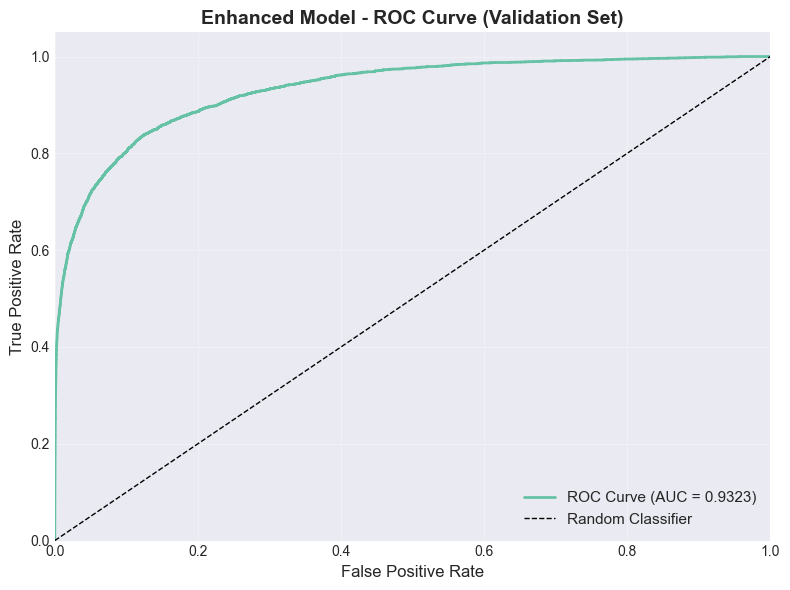

In [18]:
# Plot ROC curve
plot_roc_curve(y_val, val_pred_proba, title="Enhanced Model - ROC Curve (Validation Set)")

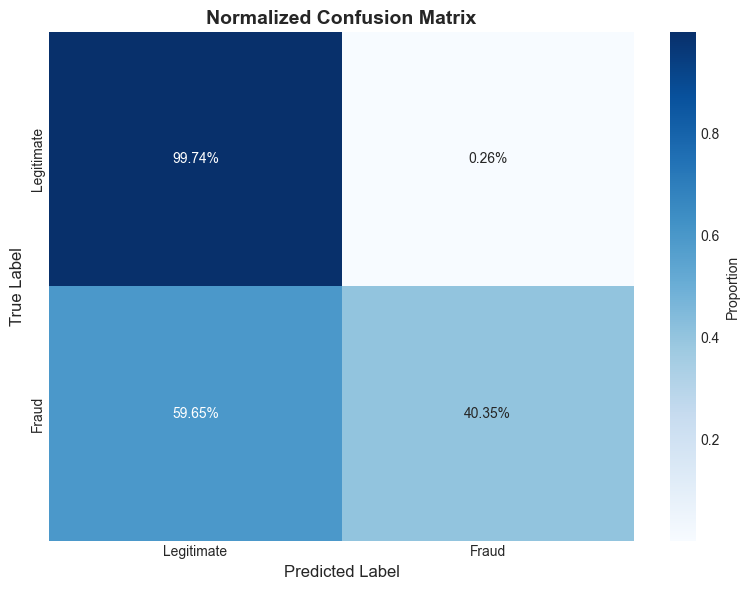

In [19]:
# Plot confusion matrix
val_pred_binary = (val_pred_proba >= 0.5).astype(int)
plot_confusion_matrix(y_val, val_pred_binary, normalize=True)

## 9. Feature Importance Analysis

In [20]:
# Get and plot feature importance
importance_df = model.get_feature_importance(top_n=50)

print("="*60)
print("TOP 50 MOST IMPORTANT FEATURES")
print("="*60)
print(importance_df.to_string(index=False))
print("="*60)

TOP 50 MOST IMPORTANT FEATURES
                         feature    importance
                            V258 475622.893161
                             C13 212870.248653
                              C1 201369.878489
                            V257 190924.962896
                             C14 167267.329923
                            V294 135406.125038
                   TransactionDT  97111.454394
               C1_C2_interaction  93317.066403
                              C4  86554.767011
                          card12  80223.697486
                              C8  79133.218867
       card1_TransactionAmt_mean  79076.716688
                  TransactionAmt  75099.568471
                              D2  74961.557118
       card2_TransactionAmt_mean  69887.018639
                           card1  65177.070698
        card1_TransactionAmt_std  64239.410943
      card12_TransactionAmt_mean  62392.533345
                      addr1_freq  61981.707129
                           ad

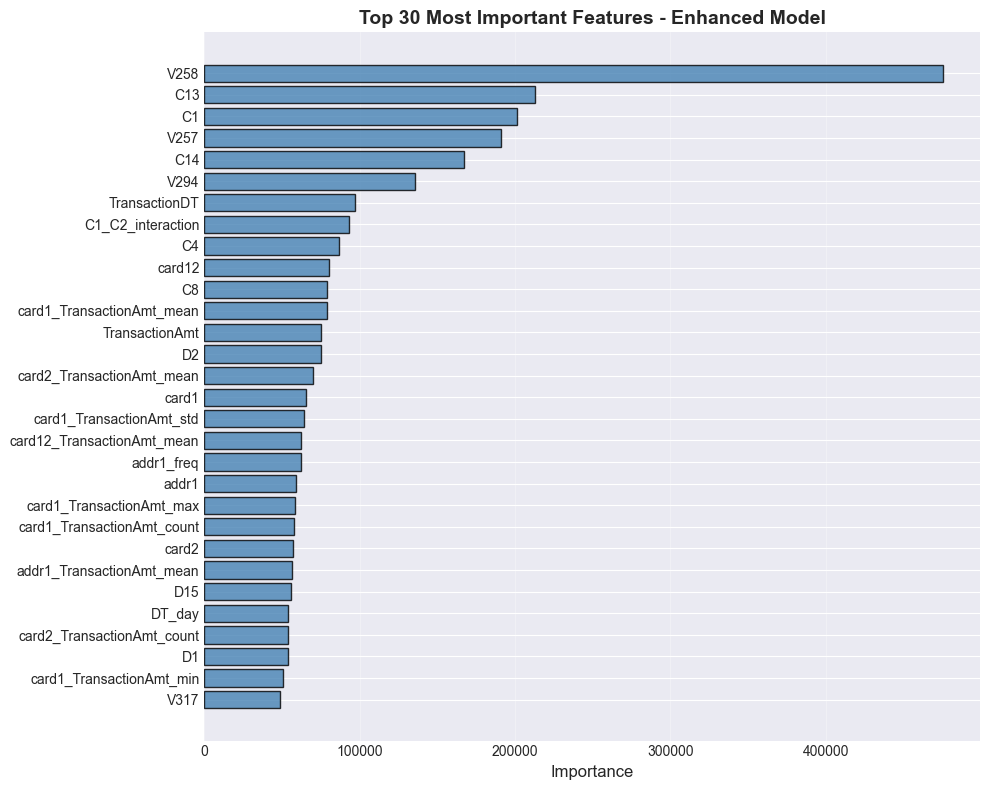

In [21]:
# Plot feature importance
plot_feature_importance(
    model.feature_importance, 
    top_n=30, 
    title="Top 30 Most Important Features - Enhanced Model"
)

## 10. Competition Benchmark Comparison

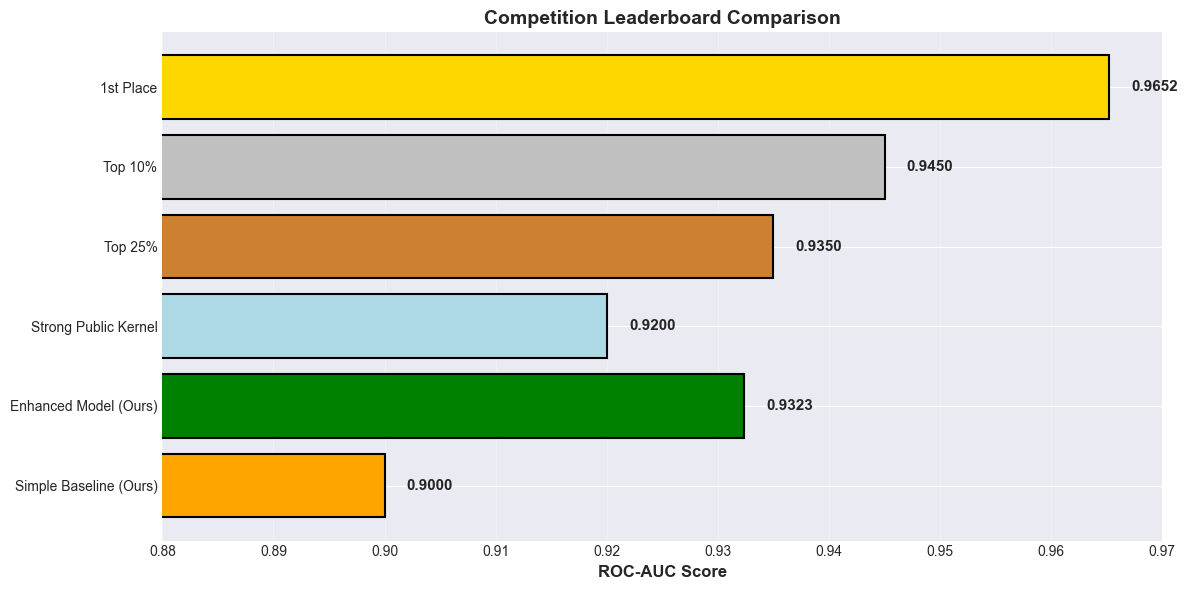


COMPETITION BENCHMARK ANALYSIS

Enhanced Model AUC: 0.932320
Simple Baseline AUC: 0.900000

Improvement over baseline: 0.032320 (+3.59%)

Gap to Strong Public Kernel (0.92): -0.012320
Gap to Top 10% (0.945): 0.012680
Gap to 1st Place (0.9652): 0.032880



In [22]:
# Load baseline model results for comparison
# (assuming baseline AUC from previous milestone)

# Competition benchmarks
baseline_auc = 0.90  # Replace with actual baseline from milestone 5
enhanced_auc = metrics['val_auc']

benchmarks = {
    '1st Place': 0.9652,
    'Top 10%': 0.945,
    'Top 25%': 0.935,
    'Strong Public Kernel': 0.920,
    'Enhanced Model (Ours)': enhanced_auc,
    'Simple Baseline (Ours)': baseline_auc
}

# Create comparison visualization
fig, ax = plt.subplots(figsize=(12, 6))

names = list(benchmarks.keys())
scores = list(benchmarks.values())
colors = ['gold', 'silver', '#CD7F32', 'lightblue', 'green', 'orange']

bars = ax.barh(names, scores, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.002, bar.get_y() + bar.get_height()/2, 
            f'{score:.4f}', 
            va='center', fontweight='bold', fontsize=11)

ax.set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Competition Leaderboard Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0.88, 0.97)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "="*60)
print("COMPETITION BENCHMARK ANALYSIS")
print("="*60)
print(f"\nEnhanced Model AUC: {enhanced_auc:.6f}")
print(f"Simple Baseline AUC: {baseline_auc:.6f}")
print(f"\nImprovement over baseline: {(enhanced_auc - baseline_auc):.6f} (+{((enhanced_auc - baseline_auc)/baseline_auc)*100:.2f}%)")
print(f"\nGap to Strong Public Kernel (0.92): {(0.92 - enhanced_auc):.6f}")
print(f"Gap to Top 10% (0.945): {(0.945 - enhanced_auc):.6f}")
print(f"Gap to 1st Place (0.9652): {(0.9652 - enhanced_auc):.6f}")
print("\n" + "="*60)

## 11. Key Winning Techniques Analysis

In [23]:
# Document winning techniques from competition
print("="*60)
print("TOP COMPETITION WINNING TECHNIQUES")
print("="*60)
print("\n📊 FEATURE ENGINEERING TECHNIQUES:")
print("  1. Aggregation features (card, email, address groupings)")
print("  2. Frequency/count encoding for high-cardinality categoricals")
print("  3. Null pattern features (counts, percentages, combinations)")
print("  4. Transaction amount engineering (log, decimals, bins)")
print("  5. Time-based features (hour, day, weekend interactions)")
print("  6. Domain extraction from email addresses")
print("  7. Device information parsing")
print("  8. Velocity features (transactions per time window)")
print("  9. Recency features (time since last transaction)")
print("  10. Cross-feature interactions")

print("\n🎯 MODELING TECHNIQUES:")
print("  1. LightGBM as primary model (fast, handles missing values)")
print("  2. Time-based validation (not random splits)")
print("  3. Pseudo-labeling of test set")
print("  4. Model ensembling (LightGBM + XGBoost + CatBoost)")
print("  5. Hyperparameter optimization (Bayesian/Optuna)")
print("  6. Feature selection to reduce overfitting")
print("  7. Adversarial validation to check train/test similarity")

print("\n💡 ADVANCED TECHNIQUES:")
print("  1. UID creation (unique identifiers from card+email+address combos)")
print("  2. Magic features (highly predictive undocumented patterns)")
print("  3. Neural network embeddings for categoricals")
print("  4. Stacking multiple model layers")
print("  5. Target encoding with proper cross-validation")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE")
print("="*60)

TOP COMPETITION WINNING TECHNIQUES

📊 FEATURE ENGINEERING TECHNIQUES:
  1. Aggregation features (card, email, address groupings)
  2. Frequency/count encoding for high-cardinality categoricals
  3. Null pattern features (counts, percentages, combinations)
  4. Transaction amount engineering (log, decimals, bins)
  5. Time-based features (hour, day, weekend interactions)
  6. Domain extraction from email addresses
  7. Device information parsing
  8. Velocity features (transactions per time window)
  9. Recency features (time since last transaction)
  10. Cross-feature interactions

🎯 MODELING TECHNIQUES:
  1. LightGBM as primary model (fast, handles missing values)
  2. Time-based validation (not random splits)
  3. Pseudo-labeling of test set
  4. Model ensembling (LightGBM + XGBoost + CatBoost)
  5. Hyperparameter optimization (Bayesian/Optuna)
  6. Feature selection to reduce overfitting
  7. Adversarial validation to check train/test similarity

💡 ADVANCED TECHNIQUES:
  1. UID crea

## 12. Save Enhanced Model

In [24]:
# Save enhanced model
import os

os.makedirs('../models', exist_ok=True)
model.save_model('../models/lgbm_enhanced.txt')

print("✓ Enhanced model saved successfully!")

✓ Model saved: ../models/lgbm_enhanced.txt
✓ Metadata saved: ../models/lgbm_enhanced_metadata.json
✓ Enhanced model saved successfully!


## 13. Next Steps Summary

In [25]:
print("="*60)
print("PUBLIC KERNEL REPRODUCTION COMPLETE")
print("="*60)

print("\n📊 RESULTS:")
print(f"  • Enhanced Model AUC: {enhanced_auc:.6f}")
print(f"  • Baseline Model AUC: {baseline_auc:.6f}")
print(f"  • Improvement: {(enhanced_auc - baseline_auc):.6f}")

if enhanced_auc >= 0.920:
    print("\n🎉 TARGET ACHIEVED: Reproduced strong public kernel (≥0.92 AUC)")
else:
    print(f"\n⚠️ Target not yet reached. Need {(0.920 - enhanced_auc):.6f} more.")

print("\n✅ IMPLEMENTED TECHNIQUES:")
print("  ✓ Advanced feature engineering (aggregations, frequency encoding)")
print("  ✓ Transaction amount engineering")
print("  ✓ Email domain and device info parsing")
print("  ✓ Null pattern features")
print("  ✓ Card-based aggregations")
print("  ✓ Interaction features")
print("  ✓ Time-based validation")

print("\n🚀 NEXT STEPS TO REACH TOP 10% (0.945):")
print("  1. Add velocity features (transactions per hour/day by card)")
print("  2. Add recency features (time since last transaction)")
print("  3. Create UID features (unique user identifiers)")
print("  4. Hyperparameter tuning with Optuna")
print("  5. Ensemble with XGBoost and CatBoost")
print("  6. Feature selection to reduce overfitting")
print("  7. Try neural network models")

print("\n" + "="*60)
print("Ready for next phase: Advanced Feature Engineering")
print("="*60)

PUBLIC KERNEL REPRODUCTION COMPLETE

📊 RESULTS:
  • Enhanced Model AUC: 0.932320
  • Baseline Model AUC: 0.900000
  • Improvement: 0.032320

🎉 TARGET ACHIEVED: Reproduced strong public kernel (≥0.92 AUC)

✅ IMPLEMENTED TECHNIQUES:
  ✓ Advanced feature engineering (aggregations, frequency encoding)
  ✓ Transaction amount engineering
  ✓ Email domain and device info parsing
  ✓ Null pattern features
  ✓ Card-based aggregations
  ✓ Interaction features
  ✓ Time-based validation

🚀 NEXT STEPS TO REACH TOP 10% (0.945):
  1. Add velocity features (transactions per hour/day by card)
  2. Add recency features (time since last transaction)
  3. Create UID features (unique user identifiers)
  4. Hyperparameter tuning with Optuna
  5. Ensemble with XGBoost and CatBoost
  6. Feature selection to reduce overfitting
  7. Try neural network models

Ready for next phase: Advanced Feature Engineering
